# Proximity Effect Analysis on Rejuvenation Interventions

This notebook contains all experiments relating to computing and characterizing T cell and NSC proximity effects across different rejuvenating intervention conditions in the exercise and partial reprogramming dataset. It uses the spatial aging clocks to compute age acceleration for the analysis.

**Associated manuscript figures/tables:**
- Figures: 4h,i
- Extended Data Figures: 9t


**Inputs required:**
- `results/clocks/anndata/exercise_spatialsmooth.h5ad` - AnnData object for exercise data with spatial aging clock predictions (generated from `4A_application_to_interventions.ipynb`)
- `results/clocks/anndata/reprogramming_spatialsmooth.h5ad` - AnnData object for partial reprogramming data with spatial aging clock predictions (generated from `4A_application_to_interventions.ipynb`)


**Conda environment used**: `requirements/merfish.txt`

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
from scipy.stats import pearsonr, spearmanr, ttest_ind
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("ticks")
from sklearn.neighbors import BallTree

from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats.multitest import multipletests
from decimal import Decimal

from ageaccel_proximity import *

In [2]:
restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

## Exercise Proximity Effect Analysis

In [3]:
# Exercise
cutoff = {'CC/ACO': 23.57728268283302, 'CTX_L1/MEN': 22.134458488559748, 'CTX_L2/3': 21.799931867417346, 'CTX_L4/5/6': 24.813794964210643, 'STR_CP/ACB': 20.752420229228946, 'STR_LS/NDB': 19.819311916176606, 'VEN': 16.22758492467233}

In [4]:
adata = sc.read_h5ad("results/clocks/anndata/exercise_spatialsmooth.h5ad")

In [5]:
# compute age acceleration
get_age_acceleration (adata)

In [6]:
# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

In [7]:
cell_pairs_to_show = []
for ct in ["NSC", "Neuroblast", "T cell"]:
    for ct2 in restricted_celltype_subset:
        cell_pairs_to_show.append((ct, ct2))

In [ ]:
condition = 'cohort'

####################################

cond_df = pd.DataFrame([])

cutoff_multiplier = 1

for celltype, ct in cell_pairs_to_show:
        
    for cond in np.unique(adata.obs[condition]):
        
        sub_adata = adata[(adata.obs["celltype"]==ct)&(adata.obs[condition]==cond)]

        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier)
        near_freq = np.mean(near_ages=="Near")

        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct,
                          adata[adata.obs[condition]==cond], label=cond,
                          min_pairs=10)
        
        cond_df = pd.concat((cond_df, df))

In [9]:
# Create condition tags
map_cond = {
    "young_control": "Young Sedentary",
    "old_control": "Old Sedentary",
    "old_exercise": "Old Exercise",
}
cond_df["label"] = [map_cond[x] for x in cond_df["label"]]
# re-order categories
cond_df['label'] = cond_df['label'].astype('category')
cond_df['label'].cat.reorder_categories(['Young Sedentary', 'Old Sedentary', 'Old Exercise'], inplace=True)


cond_df["Near Cell Conditioned"] = cond_df["Near Cell"].astype(str)+" ("+cond_df["label"].astype(str)+")"

/local/scratch/edsun/slrmtmp.43158897/ipykernel_8952/2380747045.py:10: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  cond_df['label'].cat.reorder_categories(['Young Sedentary', 'Old Sedentary', 'Old Exercise'], inplace=True)


/local/scratch/edsun/slrmtmp.43158897/ipykernel_8952/1534559051.py:31: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.catplot(


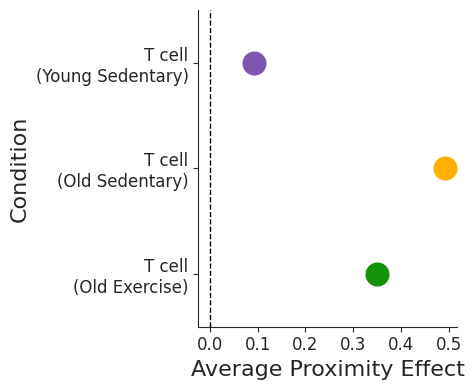

In [10]:
# Cat plots for Exercise Proximity Effects (T cell)

celltypes = []
average_effects = []
colors = []


effector_cells = ["T cell (Young Sedentary)", "T cell (Old Sedentary)", "T cell (Old Exercise)"]

sub_cond_df = cond_df[cond_df['Near Cell Conditioned'].isin(effector_cells)].copy()
sub_cond_df["Near Cell Conditioned"] = [x.split(" (")[0]+"\n("+x.split(" (")[1] for x in sub_cond_df["Near Cell Conditioned"]]


for ct in np.unique(sub_cond_df["Near Cell Conditioned"]):
    average_effect = np.nanmean(sub_cond_df[sub_cond_df["Near Cell Conditioned"]==ct]["Aging Effect"])
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    
    celltypes.append(ct)
    average_effects.append(average_effect)
    colors.append(color)


palette = {"T cell\n(Young Sedentary)":"#7F57B2",
           "T cell\n(Old Sedentary)":"#FEAF00",
           "T cell\n(Old Exercise)":"#149309"}


g = sns.catplot(
    x=average_effects,
    y=celltypes,
    palette=palette,
    s = 300,
    order=["T cell\n(Young Sedentary)", "T cell\n(Old Sedentary)", "T cell\n(Old Exercise)"],
    height=4,
    aspect=1.2
)

plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Condition", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f"plots/exercise/exercise_average_aging_effect_tcell_catplot.pdf",
           bbox_inches='tight')
plt.show()

/local/scratch/edsun/slrmtmp.43158897/ipykernel_8952/3169867643.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.catplot(


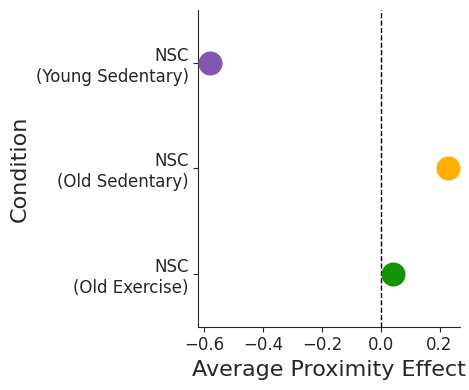

In [11]:
# Cat plots for Exercise Proximity Effects (NSC)

celltypes = []
average_effects = []
colors = []


effector_cells = ["NSC (Young Sedentary)", "NSC (Old Sedentary)", "NSC (Old Exercise)"]

sub_cond_df = cond_df[cond_df['Near Cell Conditioned'].isin(effector_cells)].copy()
sub_cond_df["Near Cell Conditioned"] = [x.split(" (")[0]+"\n("+x.split(" (")[1] for x in sub_cond_df["Near Cell Conditioned"]]


for ct in np.unique(sub_cond_df["Near Cell Conditioned"]):
    average_effect = np.nanmean(sub_cond_df[sub_cond_df["Near Cell Conditioned"]==ct]["Aging Effect"])
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    
    celltypes.append(ct)
    average_effects.append(average_effect)
    colors.append(color)


palette = {"NSC\n(Young Sedentary)":"#7F57B2",
           "NSC\n(Old Sedentary)":"#FEAF00",
           "NSC\n(Old Exercise)":"#149309"}

g = sns.catplot(
    x=average_effects,
    y=celltypes,
    palette=palette,
    s=300,
    order=["NSC\n(Young Sedentary)", "NSC\n(Old Sedentary)", "NSC\n(Old Exercise)"],
    height=4,
    aspect=1.2
)

plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Condition", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f"plots/exercise/exercise_average_aging_effect_nsc_catplot.pdf",
           bbox_inches='tight')
plt.show()

# Reprogramming Proximity Effect Analysis

In [12]:
cutoff = {'CC/ACO': 23.64468336308264, 'CTX_L1/MEN': 20.536925931507863, 'CTX_L2/3': 21.04037750284547, 'CTX_L4/5/6': 24.05456885431489, 'STR_CP/ACB': 20.896227512408654, 'STR_LS/NDB': 20.17505733971367, 'VEN': 17.258839036280175}

In [13]:
adata = sc.read_h5ad("results/clocks/anndata/reprogramming_spatialsmooth.h5ad")

In [14]:
# compute age acceleration
get_age_acceleration (adata)

In [15]:
# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

In [16]:
adata_celltypes = np.unique(adata.obs.celltype)

cell_pairs_to_show = []
for ct in ["NSC", "Neuroblast"]:
    for ct2 in [x for x in restricted_celltype_subset if x in adata_celltypes]:
        cell_pairs_to_show.append((ct, ct2))

In [17]:
condition = 'cohort'

####################################

cond_df = pd.DataFrame([])

cutoff_multiplier = 1

for celltype, ct in cell_pairs_to_show:
        
    for cond in np.unique(adata.obs[condition]):
        
        sub_adata = adata[(adata.obs["celltype"]==ct)&(adata.obs[condition]==cond)]

        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier)
        near_freq = np.mean(near_ages=="Near")

        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct,
                          adata[adata.obs[condition]==cond], label=cond,
                          min_pairs=10)
        
        cond_df = pd.concat((cond_df, df))

/oak/stanford/scg/lab_abrunet1/Eric/MERFISH/ageaccel_proximity.py:199: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p = ttest_ind(adata.obs['normalized_age_acceleration'].copy()[near_ages=="Near"],
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/oak/stanford/scg/lab_abrunet1/Eric/MERFISH/ageaccel_proximity.py:199: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unre

In [18]:
# Create condition tags
map_cond = {
    "young_notreatment": "Young Control",
    "old_notreatment": "Old Control",
    "old_treatment": "Old OSKM",
}
cond_df["label"] = [map_cond[x] for x in cond_df["label"]]
# re-order categories
cond_df['label'] = cond_df['label'].astype('category')
cond_df['label'].cat.reorder_categories(['Young Control', 'Old Control', 'Old OSKM'], inplace=True)


cond_df["Near Cell Conditioned"] = cond_df["Near Cell"].astype(str)+" ("+cond_df["label"].astype(str)+")"

/local/scratch/edsun/slrmtmp.43158897/ipykernel_8952/1061162947.py:10: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  cond_df['label'].cat.reorder_categories(['Young Control', 'Old Control', 'Old OSKM'], inplace=True)


/local/scratch/edsun/slrmtmp.43158897/ipykernel_8952/2389032945.py:29: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.catplot(


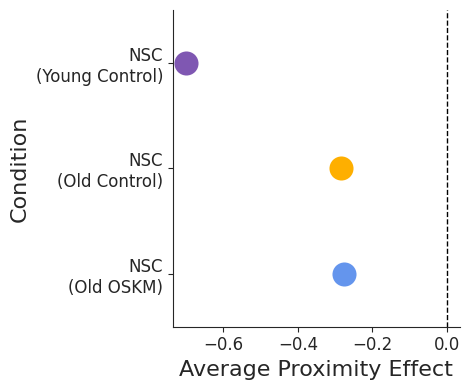

In [19]:
celltypes = []
average_effects = []
colors = []


effector_cells = ["NSC (Young Control)", "NSC (Old Control)", "NSC (Old OSKM)"]

sub_cond_df = cond_df[cond_df['Near Cell Conditioned'].isin(effector_cells)].copy()
sub_cond_df["Near Cell Conditioned"] = [x.split(" (")[0]+"\n("+x.split(" (")[1] for x in sub_cond_df["Near Cell Conditioned"]]


for ct in np.unique(sub_cond_df["Near Cell Conditioned"]):
    average_effect = np.nanmean(sub_cond_df[sub_cond_df["Near Cell Conditioned"]==ct]["Aging Effect"])
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    
    celltypes.append(ct)
    average_effects.append(average_effect)
    colors.append(color)



palette = {"NSC\n(Young Control)":"#7F57B2",
           "NSC\n(Old Control)":"#FEAF00",
           "NSC\n(Old OSKM)":"cornflowerblue"}

g = sns.catplot(
    x=average_effects,
    y=celltypes,
    palette=palette,
    s=300,
    order=["NSC\n(Young Control)", "NSC\n(Old Control)", "NSC\n(Old OSKM)"],
    height=4,
    aspect=1.2
)

plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Condition", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f"plots/reprogramming/reprogramming_average_aging_effect_nsc_catplot.pdf",
           bbox_inches='tight')
plt.show()